# GeoBERT Model Evaluation

This notebook evaluates the trained GeoBERT model on the test set and visualizes predictions using interactive Folium maps.

In [1]:
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import folium
from folium.plugins import HeatMap

from geobert import Inferencer
from geobert.metrics import haversine_distance_m

pd.set_option('display.max_columns', None)
%matplotlib inline

## Configuration

In [2]:
# Paths
CHECKPOINT_DIR = Path("../outputs/checkpoints")
TEST_DATA_PATH = CHECKPOINT_DIR / "test_data.parquet"

# NYC center for maps
NYC_CENTER = [40.7128, -74.0060]

# Error thresholds for color coding (meters)
ERROR_THRESHOLDS = {
    'good': 100,      # < 100m = green
    'medium': 500,    # 100-500m = yellow
    # > 500m = red
}

ERROR_COLORS = {
    'good': 'green',
    'medium': 'orange',
    'bad': 'red'
}

## 1. Load Model and Test Data

In [3]:
# Load inferencer
print(f"Loading model from: {CHECKPOINT_DIR}")
inferencer = Inferencer(CHECKPOINT_DIR)
print(f"Model loaded on device: {inferencer.device}")

Loading model from: ../outputs/checkpoints
Model loaded on device: cuda


In [4]:
# Load test data
print(f"Loading test data from: {TEST_DATA_PATH}")
test_df = pd.read_parquet(TEST_DATA_PATH)
test_df = test_df.sample(n=1000, random_state=42).reset_index(drop=True)  # Sample for quick testing
print(f"Test set size: {len(test_df):,} samples")
test_df.head()

Loading test data from: ../outputs/checkpoints/test_data.parquet
Test set size: 1,000 samples


,address,latitude,longitude
0,"422 BURNS ST, Queens, NY 11375",40.712711,-73.834969
1,"21 ALEXANDER AVE, Staten Island, NY 10312",40.557957,-74.179550
2,"67 COUNTRY DR N, Staten Island, NY 10314",40.588566,-74.163322
3,"85 BRICKTOWN WAY, Staten Island, NY 10309",40.530022,-74.229271
4,"227-22 67 AVE, Queens, NY 11364",40.746822,-73.748398


## 2. Run Inference on Test Set

In [5]:
# Run batch inference
addresses = test_df['address'].tolist()

print(f"Running inference on {len(addresses):,} addresses...")
start_time = time.time()

pred_lats, pred_lons = inferencer.predict_batch(addresses, batch_size=128)

inference_time = time.time() - start_time
print(f"Inference completed in {inference_time:.2f}s")
print(f"Throughput: {len(addresses) / inference_time:.0f} addresses/second")

Running inference on 1,000 addresses...
Inference completed in 0.36s
Throughput: 2755 addresses/second


In [6]:
# Add predictions to dataframe
test_df['pred_latitude'] = pred_lats
test_df['pred_longitude'] = pred_lons

# Calculate error distances using haversine formula
actual_lats = torch.tensor(test_df['latitude'].values)
actual_lons = torch.tensor(test_df['longitude'].values)
pred_lat_tensor = torch.tensor(pred_lats)
pred_lon_tensor = torch.tensor(pred_lons)

distances_m = haversine_distance_m(actual_lats, actual_lons, pred_lat_tensor, pred_lon_tensor)
test_df['error_m'] = distances_m.numpy()

test_df.head()

,address,latitude,longitude,pred_latitude,pred_longitude,error_m
0,"422 BURNS ST, Queens, NY 11375",40.712711,-73.834969,40.715137,-73.838196,383.097046
1,"21 ALEXANDER AVE, Staten Island, NY 10312",40.557957,-74.179550,40.556820,-74.180702,159.531235
2,"67 COUNTRY DR N, Staten Island, NY 10314",40.588566,-74.163322,40.586246,-74.164879,289.455688
3,"85 BRICKTOWN WAY, Staten Island, NY 10309",40.530022,-74.229271,40.530556,-74.237358,686.061890
4,"227-22 67 AVE, Queens, NY 11364",40.746822,-73.748398,40.746967,-73.748421,16.233562


## 3. Evaluation Metrics

In [7]:
# Compute metrics
lat_errors = test_df['pred_latitude'] - test_df['latitude']
lon_errors = test_df['pred_longitude'] - test_df['longitude']

metrics = {
    'MAE Latitude (degrees)': np.abs(lat_errors).mean(),
    'MAE Longitude (degrees)': np.abs(lon_errors).mean(),
    'RMSE Latitude (degrees)': np.sqrt((lat_errors ** 2).mean()),
    'RMSE Longitude (degrees)': np.sqrt((lon_errors ** 2).mean()),
    'Mean Distance Error (m)': test_df['error_m'].mean(),
    'Median Distance Error (m)': test_df['error_m'].median(),
    'Std Distance Error (m)': test_df['error_m'].std(),
    '90th Percentile Error (m)': np.percentile(test_df['error_m'], 90),
    '95th Percentile Error (m)': np.percentile(test_df['error_m'], 95),
    '99th Percentile Error (m)': np.percentile(test_df['error_m'], 99),
}

print("=" * 50)
print("EVALUATION METRICS")
print("=" * 50)
for name, value in metrics.items():
    print(f"{name:35s}: {value:.4f}")
print("=" * 50)

EVALUATION METRICS
MAE Latitude (degrees)             : 0.0010
MAE Longitude (degrees)            : 0.0012
RMSE Latitude (degrees)            : 0.0013
RMSE Longitude (degrees)           : 0.0017
Mean Distance Error (m)            : 163.5804
Median Distance Error (m)          : 136.8888
Std Distance Error (m)             : 125.0270
90th Percentile Error (m)          : 301.8290
95th Percentile Error (m)          : 371.9547
99th Percentile Error (m)          : 563.0770


In [8]:
# Accuracy at different thresholds
thresholds = [50, 100, 200, 500, 1000, 2000]

print("\nAccuracy at Distance Thresholds:")
print("-" * 40)
for thresh in thresholds:
    accuracy = (test_df['error_m'] < thresh).mean() * 100
    print(f"Within {thresh:5d}m: {accuracy:6.2f}%")


Accuracy at Distance Thresholds:
----------------------------------------
Within    50m:  11.30%
Within   100m:  34.70%
Within   200m:  70.80%
Within   500m:  98.50%
Within  1000m:  99.80%
Within  2000m: 100.00%


## 4. Error Distribution

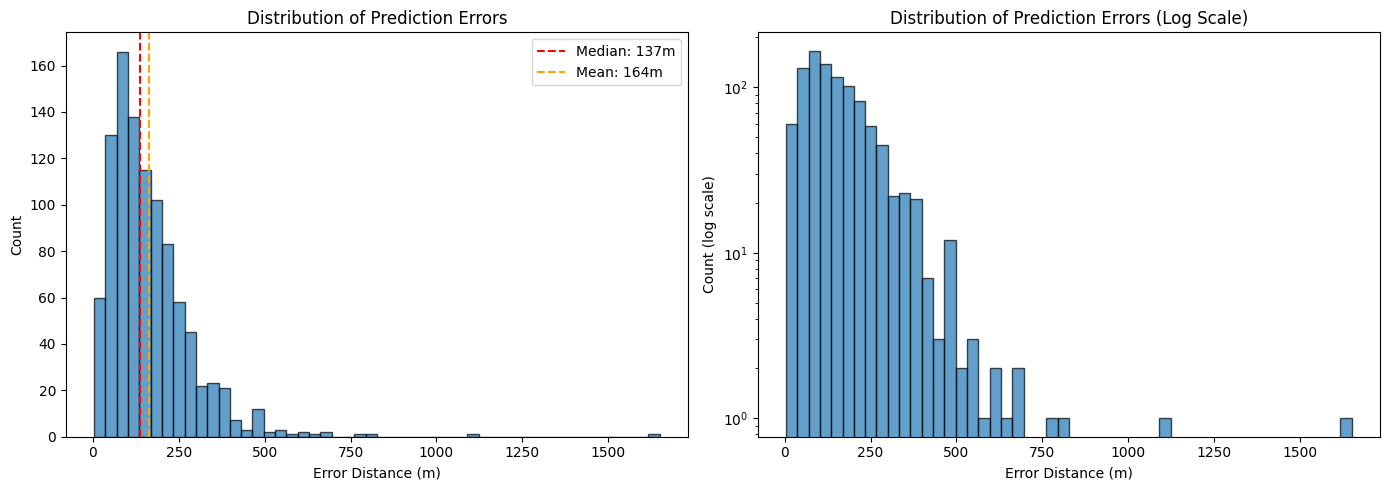

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of errors (capped at 2000m for visibility)
errors_capped = test_df['error_m'].clip(upper=2000)
axes[0].hist(errors_capped, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(test_df['error_m'].median(), color='red', linestyle='--', label=f'Median: {test_df["error_m"].median():.0f}m')
axes[0].axvline(test_df['error_m'].mean(), color='orange', linestyle='--', label=f'Mean: {test_df["error_m"].mean():.0f}m')
axes[0].set_xlabel('Error Distance (m)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Prediction Errors')
axes[0].legend()

# Log-scale histogram for full range
axes[1].hist(test_df['error_m'], bins=50, edgecolor='black', alpha=0.7, log=True)
axes[1].set_xlabel('Error Distance (m)')
axes[1].set_ylabel('Count (log scale)')
axes[1].set_title('Distribution of Prediction Errors (Log Scale)')

plt.tight_layout()
plt.show()

In [10]:
# Categorize errors
def categorize_error(error_m):
    if error_m < ERROR_THRESHOLDS['good']:
        return 'good'
    elif error_m < ERROR_THRESHOLDS['medium']:
        return 'medium'
    else:
        return 'bad'

test_df['error_category'] = test_df['error_m'].apply(categorize_error)

category_counts = test_df['error_category'].value_counts()
category_pcts = category_counts / len(test_df) * 100

print("Error Categories:")
print(f"  Good (<{ERROR_THRESHOLDS['good']}m):     {category_counts.get('good', 0):,} ({category_pcts.get('good', 0):.1f}%)")
print(f"  Medium ({ERROR_THRESHOLDS['good']}-{ERROR_THRESHOLDS['medium']}m): {category_counts.get('medium', 0):,} ({category_pcts.get('medium', 0):.1f}%)")
print(f"  Bad (>{ERROR_THRESHOLDS['medium']}m):    {category_counts.get('bad', 0):,} ({category_pcts.get('bad', 0):.1f}%)")

Error Categories:
  Good (<100m):     347 (34.7%)
  Medium (100-500m): 638 (63.8%)
  Bad (>500m):    15 (1.5%)


## 5. Interactive Map Visualizations

### 5.1 Prediction vs Ground Truth

Shows predicted (red) and actual (green) locations connected by lines. Click markers for details.

In [11]:
# Sample 500 points for visualization
sample_df = test_df.sample(n=min(500, len(test_df)), random_state=42)

m_compare = folium.Map(location=NYC_CENTER, zoom_start=11, tiles='CartoDB positron')

for _, row in sample_df.iterrows():
    actual = [row['latitude'], row['longitude']]
    predicted = [row['pred_latitude'], row['pred_longitude']]
    
    # Line connecting actual to predicted
    folium.PolyLine(
        [actual, predicted],
        color='gray',
        weight=1,
        opacity=0.5
    ).add_to(m_compare)
    
    # Actual location (green)
    folium.CircleMarker(
        location=actual,
        radius=4,
        color='green',
        fill=True,
        fill_opacity=0.7,
        popup=f"<b>Actual</b><br>{row['address']}<br>Error: {row['error_m']:.0f}m"
    ).add_to(m_compare)
    
    # Predicted location (red)
    folium.CircleMarker(
        location=predicted,
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=f"<b>Predicted</b><br>{row['address']}<br>Error: {row['error_m']:.0f}m"
    ).add_to(m_compare)

# Add legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white;
            padding: 10px; border: 2px solid gray; border-radius: 5px;">
    <b>Legend</b><br>
    <i style="background: green; width: 12px; height: 12px; display: inline-block; border-radius: 50%;"></i> Actual<br>
    <i style="background: red; width: 12px; height: 12px; display: inline-block; border-radius: 50%;"></i> Predicted<br>
    <i style="background: gray; width: 20px; height: 2px; display: inline-block;"></i> Error line
</div>
'''
m_compare.get_root().html.add_child(folium.Element(legend_html))

m_compare

### 5.2 Error Heatmap

Geographic distribution of prediction errors. Brighter areas indicate higher error concentrations.

In [12]:
# Create heatmap weighted by error magnitude
# Use a larger sample for better heatmap coverage
heat_sample = test_df.sample(n=min(10000, len(test_df)), random_state=42)

# Normalize errors for heatmap weights (0-1 scale, capped at 1000m)
max_error_for_weight = 1000
heat_sample['weight'] = (heat_sample['error_m'].clip(upper=max_error_for_weight) / max_error_for_weight)

# Create weighted heatmap data: [lat, lon, weight]
heat_data = heat_sample[['latitude', 'longitude', 'weight']].values.tolist()

m_heat = folium.Map(location=NYC_CENTER, zoom_start=11, tiles='CartoDB dark_matter')

HeatMap(
    heat_data,
    min_opacity=0.3,
    radius=12,
    blur=15,
    max_zoom=13
).add_to(m_heat)

# Add title
title_html = '''
<div style="position: fixed; top: 10px; left: 50%; transform: translateX(-50%); z-index: 1000; 
            background-color: rgba(0,0,0,0.7); color: white; padding: 10px; border-radius: 5px;">
    <b>Prediction Error Heatmap</b><br>
    <small>Brighter = Higher Errors</small>
</div>
'''
m_heat.get_root().html.add_child(folium.Element(title_html))

m_heat

### 5.3 Error-Colored Markers

Markers colored by error magnitude:
- **Green**: < 100m (good)
- **Orange**: 100-500m (medium)
- **Red**: > 500m (bad)

In [13]:
# Sample for error-colored visualization
marker_sample = test_df.sample(n=min(1000, len(test_df)), random_state=42)

m_errors = folium.Map(location=NYC_CENTER, zoom_start=11, tiles='CartoDB positron')

for _, row in marker_sample.iterrows():
    color = ERROR_COLORS[row['error_category']]
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=color,
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['address']}<br>Error: {row['error_m']:.0f}m"
    ).add_to(m_errors)

# Add legend
legend_html = f'''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white;
            padding: 10px; border: 2px solid gray; border-radius: 5px;">
    <b>Error Categories</b><br>
    <i style="background: green; width: 12px; height: 12px; display: inline-block; border-radius: 50%;"></i> Good (&lt;{ERROR_THRESHOLDS['good']}m)<br>
    <i style="background: orange; width: 12px; height: 12px; display: inline-block; border-radius: 50%;"></i> Medium ({ERROR_THRESHOLDS['good']}-{ERROR_THRESHOLDS['medium']}m)<br>
    <i style="background: red; width: 12px; height: 12px; display: inline-block; border-radius: 50%;"></i> Bad (&gt;{ERROR_THRESHOLDS['medium']}m)
</div>
'''
m_errors.get_root().html.add_child(folium.Element(legend_html))

m_errors

### 5.4 Worst Predictions

Visualize the predictions with the highest errors to understand failure cases.

In [14]:
# Get top 50 worst predictions
worst_df = test_df.nlargest(50, 'error_m')

print(f"Top 10 Worst Predictions:")
print(worst_df[['address', 'error_m']].head(10).to_string(index=False))

Top 10 Worst Predictions:
                                   address     error_m
         225 W  34 ST, Manhattan, NY 10122 1649.790771
3511 VICTORY BLVD, Staten Island, NY 10314 1120.749512
   29 JENNIFER CT, Staten Island, NY 10314  812.477600
            510 5 AVE, Manhattan, NY 10036  764.463867
            152 BROADWAY, Queens, NY 11414  686.826355
 85 BRICKTOWN WAY, Staten Island, NY 10309  686.061890
        4401 BROADWAY, Manhattan, NY 10040  642.071716
            1321 SHORE DR, Bronx, NY 10465  612.801819
 23 MERRYMOUNT ST, Staten Island, NY 10314  601.102966
    236 FINLAY ST, Staten Island, NY 10307  565.838501


In [15]:
m_worst = folium.Map(location=NYC_CENTER, zoom_start=10, tiles='CartoDB positron')

for _, row in worst_df.iterrows():
    actual = [row['latitude'], row['longitude']]
    predicted = [row['pred_latitude'], row['pred_longitude']]
    
    # Line connecting actual to predicted
    folium.PolyLine(
        [actual, predicted],
        color='red',
        weight=2,
        opacity=0.7
    ).add_to(m_worst)
    
    # Actual location
    folium.CircleMarker(
        location=actual,
        radius=6,
        color='green',
        fill=True,
        popup=f"<b>Actual</b><br>{row['address']}<br>Error: {row['error_m']:.0f}m"
    ).add_to(m_worst)
    
    # Predicted location
    folium.CircleMarker(
        location=predicted,
        radius=5,
        color='red',
        fill=True,
        popup=f"<b>Predicted</b><br>Error: {row['error_m']:.0f}m"
    ).add_to(m_worst)

m_worst

## 6. Save Maps

In [16]:
# Create output directory
output_dir = Path("../outputs/maps")
output_dir.mkdir(parents=True, exist_ok=True)

maps_to_save = {
    'evaluation_pred_vs_actual.html': m_compare,
    'evaluation_error_heatmap.html': m_heat,
    'evaluation_error_markers.html': m_errors,
    'evaluation_worst_predictions.html': m_worst,
}

for filename, map_obj in maps_to_save.items():
    filepath = output_dir / filename
    map_obj.save(str(filepath))
    print(f"Saved: {filepath}")

Saved: ../outputs/maps/evaluation_pred_vs_actual.html
Saved: ../outputs/maps/evaluation_error_heatmap.html
Saved: ../outputs/maps/evaluation_error_markers.html
Saved: ../outputs/maps/evaluation_worst_predictions.html


## Summary

In [17]:
print("=" * 60)
print("MODEL EVALUATION SUMMARY")
print("=" * 60)
print(f"\nTest Set Size: {len(test_df):,} samples")
print(f"Inference Time: {inference_time:.2f}s ({len(test_df) / inference_time:.0f} samples/sec)")
print(f"\nKey Metrics:")
print(f"  Mean Distance Error:   {metrics['Mean Distance Error (m)']:.1f}m")
print(f"  Median Distance Error: {metrics['Median Distance Error (m)']:.1f}m")
print(f"  90th Percentile Error: {metrics['90th Percentile Error (m)']:.1f}m")
print(f"\nError Distribution:")
print(f"  Good (<{ERROR_THRESHOLDS['good']}m):     {category_pcts.get('good', 0):.1f}%")
print(f"  Medium ({ERROR_THRESHOLDS['good']}-{ERROR_THRESHOLDS['medium']}m): {category_pcts.get('medium', 0):.1f}%")
print(f"  Bad (>{ERROR_THRESHOLDS['medium']}m):    {category_pcts.get('bad', 0):.1f}%")
print("=" * 60)

MODEL EVALUATION SUMMARY

Test Set Size: 1,000 samples
Inference Time: 0.36s (2755 samples/sec)

Key Metrics:
  Mean Distance Error:   163.6m
  Median Distance Error: 136.9m
  90th Percentile Error: 301.8m

Error Distribution:
  Good (<100m):     34.7%
  Medium (100-500m): 63.8%
  Bad (>500m):    1.5%
